In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
import copy, math

In [3]:
import plotly.express as px

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

In [6]:
def format_comma(num):
    return f'{num:,.0f}'

# Setup

## Define all keys

In [7]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [8]:
state_labels = list(state_key.values())
state_labels

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu Natal',
 'Limpopo',
 'Mpumalanga',
 'Northern Cape',
 'North-West',
 'Western Cape']

In [9]:
#not required
state_filter_d = copy.deepcopy(state_filter)
state_filter_d.append('Date')
state_filter_d

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [10]:
state_filter_t = copy.deepcopy(state_filter)
state_filter_t.insert(0,'Total RSA')
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [11]:
state_filter_all = copy.deepcopy(state_filter)
state_filter_all.insert(0,'Total RSA')
state_filter_all.append('Date')
state_filter_all

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

## Download SA population stats

In [12]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

Province       Pop
0        Gauteng  15176115
1  KwaZulu-Natal  11289086
2   Western Cape   6844272
3   Eastern Cape   6712276
4        Limpopo   5982584
5     Mpumalanga   4592187
6      Northwest   4027160
7     Free State   2887465
8  Northern Cape   1263875

In [13]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [14]:
province_pops.iloc[0]['Pop']

15176115

In [15]:
state_pop = {
    'EC': 6712276,
    'FS': 2887465,
    'GP': 15176115,
    'KZN': 11289086,
    'LP': 5982584,
    'MP': 4592187,
    'NC': 1263875,
    'NW': 4027160,
    'WC': 6844272
}

# SQL Import Test

In [16]:
import sqlite3

con = sqlite3.connect("../db.sqlite3")

df = pd.read_sql_query('SELECT * FROM dashboard_coviddata', con)
df

id        date var  ec  fs  gp  kzn  lp  mp  nc  nw  wc  unknown  total  \
0   1  2020-10-28   C   1   2   3    4   5   6   7   8   9        0     10   

  source  
0    ABC

# Download Data

## Download case data

In [17]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_cases_i

YYYYMMDD       EC       FS        GP       KZN       LP       MP  \
date                                                                           
2020-03-05  20200305      0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307      0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308      0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309      0.0      0.0       1.0       6.0      0.0      0.0   
2020-03-11  20200311      0.0      0.0       5.0       7.0      0.0      0.0   
...              ...      ...      ...       ...       ...      ...      ...   
2020-10-26  20201026  94182.0  55843.0  227350.0  122342.0  17234.0  29384.0   
2020-10-27  20201027  94497.0  56018.0  227559.0  122447.0  17277.0  29473.0   
2020-10-28  20201028  95050.0  56196.0  227833.0  122624.0  17374.0  29553.0   
2020-10-29  20201029  95559.0  56545.0  228128.0  122807.0  17439.0  29652.0   
2020-10-30  20201030  96093.0  56746.0  228432.0  122954.0  17497.0  29763.0   

                 NC       NW        WC  UNKNOWN   total  \
date                                                      
2020-03-05      0.0      0.0       0.0      0.0       1   
2020-03-07      0.0      0.0       0.0      0.0       2   
2020-03-08      0.0      0.0       0.0      0.0       3   
2020-03-09      0.0      0.0       0.0      0.0       7   
2020-03-11      0.0      0.0       1.0      0.0      13   
...             ...      ...       ...      ...     ...   
2020-10-26  21433.0  32759.0  116242.0      0.0  716759   
2020-10-27  21458.0  32804.0  116318.0      0.0  717851   
2020-10-28  21560.0  32956.0  116568.0      0.0  719714   
2020-10-29  21691.0  33097.0  116852.0      0.0  721770   
2020-10-30  21836.0  33256.0  117105.0      0.0  723682   

                                                       source  
date                                                           
2020-03-05                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
2020-03-11                                                NaN  
...                                                       ...  
2020-10-26  https://sacoronavirus.co.za/2020/10/26/update-...  
2020-10-27  https://sacoronavirus.co.za/2020/10/27/update-...  
2020-10-28  https://sacoronavirus.co.za/2020/10/28/update-...  
2020-10-29  https://sacoronavirus.co.za/2020/10/29/update-...  
2020-10-30  https://sacoronavirus.co.za/2020/10/30/update-...  

[238 rows x 13 columns]

In [18]:
casezero = states_cases_i.index[0]
caselast = states_cases_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-10-30 00:00:00'))

In [19]:
idx = pd.date_range(casezero, caselast)
idx

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14',
               ...
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24',
               '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29', '2020-10-30'],
              dtype='datetime64[ns]', length=240, freq='D')

In [20]:
states_cases_i = states_cases_i.reindex(idx, method='ffill')
states_cases_i = states_cases_i.rename(columns={'total':'Total RSA'})
states_cases_i

YYYYMMDD       EC       FS        GP       KZN       LP       MP  \
2020-03-05  20200305      0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-06  20200305      0.0      0.0       0.0       1.0      0.0      0.0   
2020-03-07  20200307      0.0      0.0       1.0       1.0      0.0      0.0   
2020-03-08  20200308      0.0      0.0       1.0       2.0      0.0      0.0   
2020-03-09  20200309      0.0      0.0       1.0       6.0      0.0      0.0   
...              ...      ...      ...       ...       ...      ...      ...   
2020-10-26  20201026  94182.0  55843.0  227350.0  122342.0  17234.0  29384.0   
2020-10-27  20201027  94497.0  56018.0  227559.0  122447.0  17277.0  29473.0   
2020-10-28  20201028  95050.0  56196.0  227833.0  122624.0  17374.0  29553.0   
2020-10-29  20201029  95559.0  56545.0  228128.0  122807.0  17439.0  29652.0   
2020-10-30  20201030  96093.0  56746.0  228432.0  122954.0  17497.0  29763.0   

                 NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0       0.0      0.0          1   
2020-03-06      0.0      0.0       0.0      0.0          1   
2020-03-07      0.0      0.0       0.0      0.0          2   
2020-03-08      0.0      0.0       0.0      0.0          3   
2020-03-09      0.0      0.0       0.0      0.0          7   
...             ...      ...       ...      ...        ...   
2020-10-26  21433.0  32759.0  116242.0      0.0     716759   
2020-10-27  21458.0  32804.0  116318.0      0.0     717851   
2020-10-28  21560.0  32956.0  116568.0      0.0     719714   
2020-10-29  21691.0  33097.0  116852.0      0.0     721770   
2020-10-30  21836.0  33256.0  117105.0      0.0     723682   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-10-26  https://sacoronavirus.co.za/2020/10/26/update-...  
2020-10-27  https://sacoronavirus.co.za/2020/10/27/update-...  
2020-10-28  https://sacoronavirus.co.za/2020/10/28/update-...  
2020-10-29  https://sacoronavirus.co.za/2020/10/29/update-...  
2020-10-30  https://sacoronavirus.co.za/2020/10/30/update-...  

[240 rows x 13 columns]

In [21]:
states_cases = states_cases_i.copy()
states_cases = states_cases.reset_index()
states_cases = states_cases.rename(columns={'index':'Date'})
states_cases

Date  YYYYMMDD       EC       FS        GP       KZN       LP  \
0   2020-03-05  20200305      0.0      0.0       0.0       1.0      0.0   
1   2020-03-06  20200305      0.0      0.0       0.0       1.0      0.0   
2   2020-03-07  20200307      0.0      0.0       1.0       1.0      0.0   
3   2020-03-08  20200308      0.0      0.0       1.0       2.0      0.0   
4   2020-03-09  20200309      0.0      0.0       1.0       6.0      0.0   
..         ...       ...      ...      ...       ...       ...      ...   
235 2020-10-26  20201026  94182.0  55843.0  227350.0  122342.0  17234.0   
236 2020-10-27  20201027  94497.0  56018.0  227559.0  122447.0  17277.0   
237 2020-10-28  20201028  95050.0  56196.0  227833.0  122624.0  17374.0   
238 2020-10-29  20201029  95559.0  56545.0  228128.0  122807.0  17439.0   
239 2020-10-30  20201030  96093.0  56746.0  228432.0  122954.0  17497.0   

          MP       NC       NW        WC  UNKNOWN  Total RSA  \
0        0.0      0.0      0.0       0.0      0.0          1   
1        0.0      0.0      0.0       0.0      0.0          1   
2        0.0      0.0      0.0       0.0      0.0          2   
3        0.0      0.0      0.0       0.0      0.0          3   
4        0.0      0.0      0.0       0.0      0.0          7   
..       ...      ...      ...       ...      ...        ...   
235  29384.0  21433.0  32759.0  116242.0      0.0     716759   
236  29473.0  21458.0  32804.0  116318.0      0.0     717851   
237  29553.0  21560.0  32956.0  116568.0      0.0     719714   
238  29652.0  21691.0  33097.0  116852.0      0.0     721770   
239  29763.0  21836.0  33256.0  117105.0      0.0     723682   

                                                source  
0                                                  NaN  
1                                                  NaN  
2                                                  NaN  
3                                                  NaN  
4                                                  NaN  
..                                                 ...  
235  https://sacoronavirus.co.za/2020/10/26/update-...  
236  https://sacoronavirus.co.za/2020/10/27/update-...  
237  https://sacoronavirus.co.za/2020/10/28/update-...  
238  https://sacoronavirus.co.za/2020/10/29/update-...  
239  https://sacoronavirus.co.za/2020/10/30/update-...  

[240 rows x 14 columns]

## Download death data

In [22]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_deaths_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_deaths_i

YYYYMMDD    EC    FS    GP   KZN   LP   MP   NC   NW    WC  \
date                                                                     
2020-03-27  20200327     0     0     0     0    0    0    0    0     1   
2020-03-28  20200328     0     0     0     1    0    0    0    0     1   
2020-03-30  20200330     0     1     0     1    0    0    0    0     1   
2020-03-31  20200331     0     1     1     2    0    0    0    0     1   
2020-04-03  20200403     0     1     1     6    0    0    0    0     1   
...              ...   ...   ...   ...   ...  ...  ...  ...  ...   ...   
2020-10-26  20201026  3560  1478  4707  3192  451  598  256  434  4332   
2020-10-27  20201027  3570  1490  4711  3197  451  601  256  434  4343   
2020-10-28  20201028  3588  1493  4713  3209  458  601  262  434  4353   
2020-10-29  20201029  3625  1498  4717  3214  458  603  262  434  4353   
2020-10-30  20201030  3646  1505  4719  3222  458  605  266  452  4357   

            UNKNOWN  total                                             source  
date                                                                           
2020-03-27        0      1  https://sacoronavirus.co.za/2020/03/27/latest-...  
2020-03-28        0      2                                                NaN  
2020-03-30        0      3                                                NaN  
2020-03-31        0      5                                                NaN  
2020-04-03        0      9                                                NaN  
...             ...    ...                                                ...  
2020-10-26        0  19008  https://sacoronavirus.co.za/2020/10/26/update-...  
2020-10-27        0  19053  https://sacoronavirus.co.za/2020/10/27/update-...  
2020-10-28        0  19111  https://sacoronavirus.co.za/2020/10/28/update-...  
2020-10-29        0  19164  https://sacoronavirus.co.za/2020/10/29/update-...  
2020-10-30        0  19230  https://sacoronavirus.co.za/2020/10/30/update-...  

[214 rows x 13 columns]

In [23]:
states_deaths_i = states_deaths_i.reindex(idx, method='ffill')
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-06         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-07         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-08         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
2020-03-09         NaN     NaN     NaN     NaN     NaN    NaN    NaN    NaN   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-10-26  20201026.0  3560.0  1478.0  4707.0  3192.0  451.0  598.0  256.0   
2020-10-27  20201027.0  3570.0  1490.0  4711.0  3197.0  451.0  601.0  256.0   
2020-10-28  20201028.0  3588.0  1493.0  4713.0  3209.0  458.0  601.0  262.0   
2020-10-29  20201029.0  3625.0  1498.0  4717.0  3214.0  458.0  603.0  262.0   
2020-10-30  20201030.0  3646.0  1505.0  4719.0  3222.0  458.0  605.0  266.0   

               NW      WC  UNKNOWN    total  \
2020-03-05    NaN     NaN      NaN      NaN   
2020-03-06    NaN     NaN      NaN      NaN   
2020-03-07    NaN     NaN      NaN      NaN   
2020-03-08    NaN     NaN      NaN      NaN   
2020-03-09    NaN     NaN      NaN      NaN   
...           ...     ...      ...      ...   
2020-10-26  434.0  4332.0      0.0  19008.0   
2020-10-27  434.0  4343.0      0.0  19053.0   
2020-10-28  434.0  4353.0      0.0  19111.0   
2020-10-29  434.0  4353.0      0.0  19164.0   
2020-10-30  452.0  4357.0      0.0  19230.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-10-26  https://sacoronavirus.co.za/2020/10/26/update-...  
2020-10-27  https://sacoronavirus.co.za/2020/10/27/update-...  
2020-10-28  https://sacoronavirus.co.za/2020/10/28/update-...  
2020-10-29  https://sacoronavirus.co.za/2020/10/29/update-...  
2020-10-30  https://sacoronavirus.co.za/2020/10/30/update-...  

[240 rows x 13 columns]

In [24]:
states_deaths_i.iloc[0, :] = states_deaths_i.iloc[0, :].replace({np.nan:0})
states_deaths_i = states_deaths_i.ffill(axis=0)
states_deaths_i = states_deaths_i.rename(columns={'total':'Total RSA'})
states_deaths_i

YYYYMMDD      EC      FS      GP     KZN     LP     MP     NC  \
2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
...                ...     ...     ...     ...     ...    ...    ...    ...   
2020-10-26  20201026.0  3560.0  1478.0  4707.0  3192.0  451.0  598.0  256.0   
2020-10-27  20201027.0  3570.0  1490.0  4711.0  3197.0  451.0  601.0  256.0   
2020-10-28  20201028.0  3588.0  1493.0  4713.0  3209.0  458.0  601.0  262.0   
2020-10-29  20201029.0  3625.0  1498.0  4717.0  3214.0  458.0  603.0  262.0   
2020-10-30  20201030.0  3646.0  1505.0  4719.0  3222.0  458.0  605.0  266.0   

               NW      WC  UNKNOWN  Total RSA  \
2020-03-05    0.0     0.0      0.0        0.0   
2020-03-06    0.0     0.0      0.0        0.0   
2020-03-07    0.0     0.0      0.0        0.0   
2020-03-08    0.0     0.0      0.0        0.0   
2020-03-09    0.0     0.0      0.0        0.0   
...           ...     ...      ...        ...   
2020-10-26  434.0  4332.0      0.0    19008.0   
2020-10-27  434.0  4343.0      0.0    19053.0   
2020-10-28  434.0  4353.0      0.0    19111.0   
2020-10-29  434.0  4353.0      0.0    19164.0   
2020-10-30  452.0  4357.0      0.0    19230.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-10-26  https://sacoronavirus.co.za/2020/10/26/update-...  
2020-10-27  https://sacoronavirus.co.za/2020/10/27/update-...  
2020-10-28  https://sacoronavirus.co.za/2020/10/28/update-...  
2020-10-29  https://sacoronavirus.co.za/2020/10/29/update-...  
2020-10-30  https://sacoronavirus.co.za/2020/10/30/update-...  

[240 rows x 13 columns]

In [25]:
states_deaths = states_deaths_i.copy()
states_deaths = states_deaths.reset_index()
states_deaths = states_deaths.rename(columns={'index':'Date'})
states_deaths

Date    YYYYMMDD      EC      FS      GP     KZN     LP     MP  \
0   2020-03-05         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
1   2020-03-06         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
2   2020-03-07         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
3   2020-03-08         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
4   2020-03-09         0.0     0.0     0.0     0.0     0.0    0.0    0.0   
..         ...         ...     ...     ...     ...     ...    ...    ...   
235 2020-10-26  20201026.0  3560.0  1478.0  4707.0  3192.0  451.0  598.0   
236 2020-10-27  20201027.0  3570.0  1490.0  4711.0  3197.0  451.0  601.0   
237 2020-10-28  20201028.0  3588.0  1493.0  4713.0  3209.0  458.0  601.0   
238 2020-10-29  20201029.0  3625.0  1498.0  4717.0  3214.0  458.0  603.0   
239 2020-10-30  20201030.0  3646.0  1505.0  4719.0  3222.0  458.0  605.0   

        NC     NW      WC  UNKNOWN  Total RSA  \
0      0.0    0.0     0.0      0.0        0.0   
1      0.0    0.0     0.0      0.0        0.0   
2      0.0    0.0     0.0      0.0        0.0   
3      0.0    0.0     0.0      0.0        0.0   
4      0.0    0.0     0.0      0.0        0.0   
..     ...    ...     ...      ...        ...   
235  256.0  434.0  4332.0      0.0    19008.0   
236  256.0  434.0  4343.0      0.0    19053.0   
237  262.0  434.0  4353.0      0.0    19111.0   
238  262.0  434.0  4353.0      0.0    19164.0   
239  266.0  452.0  4357.0      0.0    19230.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
235  https://sacoronavirus.co.za/2020/10/26/update-...  
236  https://sacoronavirus.co.za/2020/10/27/update-...  
237  https://sacoronavirus.co.za/2020/10/28/update-...  
238  https://sacoronavirus.co.za/2020/10/29/update-...  
239  https://sacoronavirus.co.za/2020/10/30/update-...  

[240 rows x 14 columns]

## Download recovery data

In [26]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_recovery_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_recovery_i

YYYYMMDD     EC     FS      GP     KZN     LP     MP     NC  \
date                                                                      
2020-04-17  20200417      9     71     479      96     18      9     10   
2020-04-18  20200418      9     71     479      96     18      9     10   
2020-04-19  20200419      9     71     479      96     18      9     10   
2020-04-20  20200420     15     74     545     151     21     14     13   
2020-04-21  20200421     15     74     545     151     21     14     13   
...              ...    ...    ...     ...     ...    ...    ...    ...   
2020-10-26  20201026  88437  40991  206750  112468  16218  28161  17504   
2020-10-27  20201027  88437  40991  207060  112591  16218  28245  17763   
2020-10-28  20201028  88437  41290  207211  112643  16218  28245  17811   
2020-10-29  20201029  89158  41290  207316  112772  16218  28324  17815   
2020-10-30  20201030  89158  42658  207697  112840  16520  28463  17932   

               NW      WC  UNKNOWN   total  \
date                                         
2020-04-17      6     205        0     903   
2020-04-18      6     205        0     903   
2020-04-19      6     205        0     903   
2020-04-20      6     216        0    1055   
2020-04-21      6     216        0    1055   
...           ...     ...      ...     ...   
2020-10-26  28804  107388        0  646721   
2020-10-27  28841  107687        0  647833   
2020-10-28  28841  107958        0  648654   
2020-10-29  28841  108201        0  649935   
2020-10-30  29356  108428        0  653052   

                                                       source  
date                                                           
2020-04-17  https://twitter.com/nicd_sa/status/12512151947...  
2020-04-18  https://twitter.com/nicd_sa/status/12515952235...  
2020-04-19  https://twitter.com/nicd_sa/status/12519270552...  
2020-04-20  https://twitter.com/nicd_sa/status/12523098244...  
2020-04-21  https://twitter.com/nicd_sa/status/12526435556...  
...                                                       ...  
2020-10-26  https://sacoronavirus.co.za/2020/10/26/update-...  
2020-10-27  https://sacoronavirus.co.za/2020/10/27/update-...  
2020-10-28  https://sacoronavirus.co.za/2020/10/28/update-...  
2020-10-29  https://sacoronavirus.co.za/2020/10/29/update-...  
2020-10-30  https://sacoronavirus.co.za/2020/10/30/update-...  

[191 rows x 13 columns]

In [27]:
states_recovery_i = states_recovery_i.reindex(idx, method='ffill')
states_recovery_i

YYYYMMDD       EC       FS        GP       KZN       LP  \
2020-03-05         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-06         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-07         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-08         NaN      NaN      NaN       NaN       NaN      NaN   
2020-03-09         NaN      NaN      NaN       NaN       NaN      NaN   
...                ...      ...      ...       ...       ...      ...   
2020-10-26  20201026.0  88437.0  40991.0  206750.0  112468.0  16218.0   
2020-10-27  20201027.0  88437.0  40991.0  207060.0  112591.0  16218.0   
2020-10-28  20201028.0  88437.0  41290.0  207211.0  112643.0  16218.0   
2020-10-29  20201029.0  89158.0  41290.0  207316.0  112772.0  16218.0   
2020-10-30  20201030.0  89158.0  42658.0  207697.0  112840.0  16520.0   

                 MP       NC       NW        WC  UNKNOWN     total  \
2020-03-05      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-06      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-07      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-08      NaN      NaN      NaN       NaN      NaN       NaN   
2020-03-09      NaN      NaN      NaN       NaN      NaN       NaN   
...             ...      ...      ...       ...      ...       ...   
2020-10-26  28161.0  17504.0  28804.0  107388.0      0.0  646721.0   
2020-10-27  28245.0  17763.0  28841.0  107687.0      0.0  647833.0   
2020-10-28  28245.0  17811.0  28841.0  107958.0      0.0  648654.0   
2020-10-29  28324.0  17815.0  28841.0  108201.0      0.0  649935.0   
2020-10-30  28463.0  17932.0  29356.0  108428.0      0.0  653052.0   

                                                       source  
2020-03-05                                                NaN  
2020-03-06                                                NaN  
2020-03-07                                                NaN  
2020-03-08                                                NaN  
2020-03-09                                                NaN  
...                                                       ...  
2020-10-26  https://sacoronavirus.co.za/2020/10/26/update-...  
2020-10-27  https://sacoronavirus.co.za/2020/10/27/update-...  
2020-10-28  https://sacoronavirus.co.za/2020/10/28/update-...  
2020-10-29  https://sacoronavirus.co.za/2020/10/29/update-...  
2020-10-30  https://sacoronavirus.co.za/2020/10/30/update-...  

[240 rows x 13 columns]

In [28]:
states_recovery_i.iloc[0, :] = states_recovery_i.iloc[0, :].replace({np.nan:0})
states_recovery_i = states_recovery_i.ffill(axis=0)
states_recovery_i = states_recovery_i.rename(columns={'total':'Total RSA'})
states_recovery_i

YYYYMMDD       EC       FS        GP       KZN       LP  \
2020-03-05         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-06         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-07         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-08         0.0      0.0      0.0       0.0       0.0      0.0   
2020-03-09         0.0      0.0      0.0       0.0       0.0      0.0   
...                ...      ...      ...       ...       ...      ...   
2020-10-26  20201026.0  88437.0  40991.0  206750.0  112468.0  16218.0   
2020-10-27  20201027.0  88437.0  40991.0  207060.0  112591.0  16218.0   
2020-10-28  20201028.0  88437.0  41290.0  207211.0  112643.0  16218.0   
2020-10-29  20201029.0  89158.0  41290.0  207316.0  112772.0  16218.0   
2020-10-30  20201030.0  89158.0  42658.0  207697.0  112840.0  16520.0   

                 MP       NC       NW        WC  UNKNOWN  Total RSA  \
2020-03-05      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-06      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-07      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-08      0.0      0.0      0.0       0.0      0.0        0.0   
2020-03-09      0.0      0.0      0.0       0.0      0.0        0.0   
...             ...      ...      ...       ...      ...        ...   
2020-10-26  28161.0  17504.0  28804.0  107388.0      0.0   646721.0   
2020-10-27  28245.0  17763.0  28841.0  107687.0      0.0   647833.0   
2020-10-28  28245.0  17811.0  28841.0  107958.0      0.0   648654.0   
2020-10-29  28324.0  17815.0  28841.0  108201.0      0.0   649935.0   
2020-10-30  28463.0  17932.0  29356.0  108428.0      0.0   653052.0   

                                                       source  
2020-03-05                                                  0  
2020-03-06                                                  0  
2020-03-07                                                  0  
2020-03-08                                                  0  
2020-03-09                                                  0  
...                                                       ...  
2020-10-26  https://sacoronavirus.co.za/2020/10/26/update-...  
2020-10-27  https://sacoronavirus.co.za/2020/10/27/update-...  
2020-10-28  https://sacoronavirus.co.za/2020/10/28/update-...  
2020-10-29  https://sacoronavirus.co.za/2020/10/29/update-...  
2020-10-30  https://sacoronavirus.co.za/2020/10/30/update-...  

[240 rows x 13 columns]

In [29]:
states_recovery = states_recovery_i.copy()
states_recovery = states_recovery.reset_index()
states_recovery = states_recovery.rename(columns={'index':'Date'})
states_recovery

Date    YYYYMMDD       EC       FS        GP       KZN       LP  \
0   2020-03-05         0.0      0.0      0.0       0.0       0.0      0.0   
1   2020-03-06         0.0      0.0      0.0       0.0       0.0      0.0   
2   2020-03-07         0.0      0.0      0.0       0.0       0.0      0.0   
3   2020-03-08         0.0      0.0      0.0       0.0       0.0      0.0   
4   2020-03-09         0.0      0.0      0.0       0.0       0.0      0.0   
..         ...         ...      ...      ...       ...       ...      ...   
235 2020-10-26  20201026.0  88437.0  40991.0  206750.0  112468.0  16218.0   
236 2020-10-27  20201027.0  88437.0  40991.0  207060.0  112591.0  16218.0   
237 2020-10-28  20201028.0  88437.0  41290.0  207211.0  112643.0  16218.0   
238 2020-10-29  20201029.0  89158.0  41290.0  207316.0  112772.0  16218.0   
239 2020-10-30  20201030.0  89158.0  42658.0  207697.0  112840.0  16520.0   

          MP       NC       NW        WC  UNKNOWN  Total RSA  \
0        0.0      0.0      0.0       0.0      0.0        0.0   
1        0.0      0.0      0.0       0.0      0.0        0.0   
2        0.0      0.0      0.0       0.0      0.0        0.0   
3        0.0      0.0      0.0       0.0      0.0        0.0   
4        0.0      0.0      0.0       0.0      0.0        0.0   
..       ...      ...      ...       ...      ...        ...   
235  28161.0  17504.0  28804.0  107388.0      0.0   646721.0   
236  28245.0  17763.0  28841.0  107687.0      0.0   647833.0   
237  28245.0  17811.0  28841.0  107958.0      0.0   648654.0   
238  28324.0  17815.0  28841.0  108201.0      0.0   649935.0   
239  28463.0  17932.0  29356.0  108428.0      0.0   653052.0   

                                                source  
0                                                    0  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
..                                                 ...  
235  https://sacoronavirus.co.za/2020/10/26/update-...  
236  https://sacoronavirus.co.za/2020/10/27/update-...  
237  https://sacoronavirus.co.za/2020/10/28/update-...  
238  https://sacoronavirus.co.za/2020/10/29/update-...  
239  https://sacoronavirus.co.za/2020/10/30/update-...  

[240 rows x 14 columns]

## Download testing data
Only for country

In [30]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests_i = states_tests_i['cumulative_tests']
states_tests_i

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-10-26    4709403.0
2020-10-27    4726875.0
2020-10-28    4752596.0
2020-10-29    4777609.0
2020-10-30    4800823.0
Name: cumulative_tests, Length: 245, dtype: float64

In [31]:
states_tests_i = states_tests_i.reindex(idx, method='ffill')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-10-26    4709403.0
2020-10-27    4726875.0
2020-10-28    4752596.0
2020-10-29    4777609.0
2020-10-30    4800823.0
Freq: D, Name: cumulative_tests, Length: 240, dtype: float64

In [32]:
states_tests_i = states_tests_i.ffill(axis=0)
states_tests_i = states_tests_i.rename('Total RSA')
states_tests_i

2020-03-05        164.0
2020-03-06        200.0
2020-03-07        241.0
2020-03-08        241.0
2020-03-09        241.0
                ...    
2020-10-26    4709403.0
2020-10-27    4726875.0
2020-10-28    4752596.0
2020-10-29    4777609.0
2020-10-30    4800823.0
Freq: D, Name: Total RSA, Length: 240, dtype: float64

In [33]:
states_tests = states_tests_i.copy()
states_tests = states_tests.reset_index()
states_tests = states_tests.rename(columns={'index':'Date'})
states_tests

Date  Total RSA
0   2020-03-05      164.0
1   2020-03-06      200.0
2   2020-03-07      241.0
3   2020-03-08      241.0
4   2020-03-09      241.0
..         ...        ...
235 2020-10-26  4709403.0
236 2020-10-27  4726875.0
237 2020-10-28  4752596.0
238 2020-10-29  4777609.0
239 2020-10-30  4800823.0

[240 rows x 2 columns]

# Analysis Per Province

In [34]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid

In [35]:
filter_cases = states_cases[state_filter_all]
analysis_cases = filter_cases.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_cases['Data'] = 'Cases'

filter_recovery = states_recovery[state_filter_all]
analysis_recovery = filter_recovery.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_recovery['Data'] = 'Recovered'

filter_deaths = states_deaths[state_filter_all]
analysis_deaths = filter_deaths.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_deaths['Data'] = 'Deaths'

In [36]:
filter_add = pd.concat([filter_deaths, filter_recovery])
filter_add = filter_add.groupby('Date').sum()
filter_add

Total RSA       EC       FS        GP       KZN       LP       MP  \
Date                                                                            
2020-03-05        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-06        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-07        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-08        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
2020-03-09        0.0      0.0      0.0       0.0       0.0      0.0      0.0   
...               ...      ...      ...       ...       ...      ...      ...   
2020-10-26   665729.0  91997.0  42469.0  211457.0  115660.0  16669.0  28759.0   
2020-10-27   666886.0  92007.0  42481.0  211771.0  115788.0  16669.0  28846.0   
2020-10-28   667765.0  92025.0  42783.0  211924.0  115852.0  16676.0  28846.0   
2020-10-29   669099.0  92783.0  42788.0  212033.0  115986.0  16676.0  28927.0   
2020-10-30   672282.0  92804.0  44163.0  212416.0  116062.0  16978.0  29068.0   

                 NC       NW        WC  
Date                                    
2020-03-05      0.0      0.0       0.0  
2020-03-06      0.0      0.0       0.0  
2020-03-07      0.0      0.0       0.0  
2020-03-08      0.0      0.0       0.0  
2020-03-09      0.0      0.0       0.0  
...             ...      ...       ...  
2020-10-26  17760.0  29238.0  111720.0  
2020-10-27  18019.0  29275.0  112030.0  
2020-10-28  18073.0  29275.0  112311.0  
2020-10-29  18077.0  29275.0  112554.0  
2020-10-30  18198.0  29808.0  112785.0  

[240 rows x 10 columns]

In [37]:
filter_sub = filter_add.rmul(-1).reset_index()
filter_sub

Date  Total RSA       EC       FS        GP       KZN       LP  \
0   2020-03-05       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
1   2020-03-06       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
2   2020-03-07       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
3   2020-03-08       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
4   2020-03-09       -0.0     -0.0     -0.0      -0.0      -0.0     -0.0   
..         ...        ...      ...      ...       ...       ...      ...   
235 2020-10-26  -665729.0 -91997.0 -42469.0 -211457.0 -115660.0 -16669.0   
236 2020-10-27  -666886.0 -92007.0 -42481.0 -211771.0 -115788.0 -16669.0   
237 2020-10-28  -667765.0 -92025.0 -42783.0 -211924.0 -115852.0 -16676.0   
238 2020-10-29  -669099.0 -92783.0 -42788.0 -212033.0 -115986.0 -16676.0   
239 2020-10-30  -672282.0 -92804.0 -44163.0 -212416.0 -116062.0 -16978.0   

          MP       NC       NW        WC  
0       -0.0     -0.0     -0.0      -0.0  
1       -0.0     -0.0     -0.0      -0.0  
2       -0.0     -0.0     -0.0      -0.0  
3       -0.0     -0.0     -0.0      -0.0  
4       -0.0     -0.0     -0.0      -0.0  
..       ...      ...      ...       ...  
235 -28759.0 -17760.0 -29238.0 -111720.0  
236 -28846.0 -18019.0 -29275.0 -112030.0  
237 -28846.0 -18073.0 -29275.0 -112311.0  
238 -28927.0 -18077.0 -29275.0 -112554.0  
239 -29068.0 -18198.0 -29808.0 -112785.0  

[240 rows x 11 columns]

In [38]:
filter_active_i = pd.concat([filter_cases, filter_sub])
filter_active_i = filter_active_i.groupby('Date').sum()
filter_active = filter_active_i.reset_index()
filter_active = filter_active.rename(columns={'index':'Date'})
filter_active

Date  Total RSA      EC       FS       GP     KZN     LP     MP  \
0   2020-03-05        1.0     0.0      0.0      0.0     1.0    0.0    0.0   
1   2020-03-06        1.0     0.0      0.0      0.0     1.0    0.0    0.0   
2   2020-03-07        2.0     0.0      0.0      1.0     1.0    0.0    0.0   
3   2020-03-08        3.0     0.0      0.0      1.0     2.0    0.0    0.0   
4   2020-03-09        7.0     0.0      0.0      1.0     6.0    0.0    0.0   
..         ...        ...     ...      ...      ...     ...    ...    ...   
235 2020-10-26    51030.0  2185.0  13374.0  15893.0  6682.0  565.0  625.0   
236 2020-10-27    50965.0  2490.0  13537.0  15788.0  6659.0  608.0  627.0   
237 2020-10-28    51949.0  3025.0  13413.0  15909.0  6772.0  698.0  707.0   
238 2020-10-29    52671.0  2776.0  13757.0  16095.0  6821.0  763.0  725.0   
239 2020-10-30    51400.0  3289.0  12583.0  16016.0  6892.0  519.0  695.0   

         NC      NW      WC  
0       0.0     0.0     0.0  
1       0.0     0.0     0.0  
2       0.0     0.0     0.0  
3       0.0     0.0     0.0  
4       0.0     0.0     0.0  
..      ...     ...     ...  
235  3673.0  3521.0  4522.0  
236  3439.0  3529.0  4288.0  
237  3487.0  3681.0  4257.0  
238  3614.0  3822.0  4298.0  
239  3638.0  3448.0  4320.0  

[240 rows x 11 columns]

In [39]:
analysis_active = filter_active.melt(id_vars='Date', var_name='Province', value_name='Value')
analysis_active['Data'] = 'Active'

In [125]:
analysis_all = pd.concat([analysis_cases, analysis_recovery, analysis_active, analysis_deaths])
analysis_all

Date   Province   Value    Data
0    2020-03-05  Total RSA     1.0   Cases
1    2020-03-06  Total RSA     1.0   Cases
2    2020-03-07  Total RSA     2.0   Cases
3    2020-03-08  Total RSA     3.0   Cases
4    2020-03-09  Total RSA     7.0   Cases
...         ...        ...     ...     ...
2395 2020-10-26         WC  4332.0  Deaths
2396 2020-10-27         WC  4343.0  Deaths
2397 2020-10-28         WC  4353.0  Deaths
2398 2020-10-29         WC  4353.0  Deaths
2399 2020-10-30         WC  4357.0  Deaths

[9600 rows x 4 columns]

In [126]:
analysis_states = analysis_all.query(f"Province != 'Total RSA'")
analysis_country = analysis_all.query(f"Province == 'Total RSA'")

In [127]:
template_h = '%{y}'

## Plot analysis for provinces

In [128]:
fig_analysis_prov = px.bar(analysis_states, title='Analysis For Provinces',
             x='Date', y='Value', color='Province', animation_frame='Data',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_prov.update_layout(plot_bgcolor="#FFF",hovermode="x", height=650)
fig_analysis_prov.update_xaxes(linecolor="#BCCCDC")
fig_analysis_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_prov.update_traces(hovertemplate=template_h)
fig_analysis_prov["layout"].pop("updatemenus") # remove play controls
fig_analysis_prov.show()
#plot_analsysis_prov = plot(fig_analysis_prov, output_type='div', include_plotlyjs=False, auto_play=False)

## Plot analysis for deaths

In [44]:
analysis_states_deaths = analysis_deaths.query(f"Province != 'Total RSA'")

In [45]:
fig_analysis_death = px.bar(analysis_states_deaths, title='Analysis For Deaths',
             x='Date', y='Value', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)

fig_analysis_death.update_layout(plot_bgcolor="#FFF")
fig_analysis_death.update_xaxes(linecolor="#BCCCDC")
fig_analysis_death.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analysis_death.update_traces(hovertemplate=None)
fig_analysis_death.update_layout(hovermode="x")
fig_analysis_death.show()
#plot_analsysis_deaths = plot(fig_analysis_death, output_type='div', include_plotlyjs=False)

## Plot analysis for South Africa

In [46]:
states_tests['Province'] = 'Total RSA'
states_tests['Data'] = 'Tests'
states_tests = states_tests.rename(columns={'Total RSA':'Value'})

In [47]:
analysis_country = pd.concat([analysis_country, states_tests])
analysis_country

Date   Province      Value   Data
0   2020-03-05  Total RSA        1.0  Cases
1   2020-03-06  Total RSA        1.0  Cases
2   2020-03-07  Total RSA        2.0  Cases
3   2020-03-08  Total RSA        3.0  Cases
4   2020-03-09  Total RSA        7.0  Cases
..         ...        ...        ...    ...
235 2020-10-26  Total RSA  4709403.0  Tests
236 2020-10-27  Total RSA  4726875.0  Tests
237 2020-10-28  Total RSA  4752596.0  Tests
238 2020-10-29  Total RSA  4777609.0  Tests
239 2020-10-30  Total RSA  4800823.0  Tests

[1200 rows x 4 columns]

In [48]:
px_data_sa = px.line(analysis_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_analysis_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [49]:
fig_analysis_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][3], secondary_y=True)
fig_analysis_sa.add_trace(px_data_sa['data'][4], secondary_y=False)

fig_analysis_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_analysis_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_analysis_sa.update_layout(title="Analysis for South Africa")

fig_analysis_sa.update_layout(plot_bgcolor="#FFF",hovermode="x")

fig_analysis_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1, linecolor="#BCCCDC")
fig_analysis_sa.update_yaxes(showspikes=True, spikethickness=1, linecolor="#BCCCDC", gridcolor='#D3D3D3')
fig_analysis_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_analysis_sa.update_traces(hovertemplate=None)
#plot_analysis_sa = plot(fig_analysis_sa, output_type='div', include_plotlyjs=False)

## Summary

In [50]:
latest_date = caselast.strftime("%d %B %Y")
f_date = caselast.strftime("%Y-%m-%d")

In [51]:
analysis_latest = analysis_country.query(f"Date == '{f_date}'")
analysis_latest

Date   Province      Value       Data
239 2020-10-30  Total RSA   723682.0      Cases
239 2020-10-30  Total RSA    51400.0     Active
239 2020-10-30  Total RSA   653052.0  Recovered
239 2020-10-30  Total RSA    19230.0     Deaths
239 2020-10-30  Total RSA  4800823.0      Tests

In [52]:
latest_cases = format_comma(analysis_latest.iloc[0]['Value'])
latest_active = analysis_latest.iloc[1]['Value']
latest_recovery = analysis_latest.iloc[2]['Value']
latest_deaths = analysis_latest.iloc[3]['Value']
latest_tests = analysis_latest.iloc[4]['Value']

In [53]:
latest_cases, latest_active, latest_recovery, latest_deaths, latest_tests

('723,682', 51400.0, 653052.0, 19230.0, 4800823.0)

## Plot analysis per province

In [54]:
max_states = max(analysis_states['Value']) * 1.05
max_states

239853.6

In [55]:
fig_analaysis_prov2 = px.line(analysis_states, title='Analysis Per Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             line_shape='spline', range_y=[0, max_states],
             color_discrete_sequence=colour_series)

fig_analaysis_prov2.update_layout(plot_bgcolor="#FFF")
fig_analaysis_prov2.update_xaxes(linecolor="#BCCCDC")
fig_analaysis_prov2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_analaysis_prov2.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_analaysis_prov2.update_yaxes(showspikes=True, spikethickness=1)
fig_analaysis_prov2.update_layout(spikedistance=1000, hoverdistance=100)

fig_analaysis_prov2.update_traces(hovertemplate=template_h)
fig_analaysis_prov2.update_layout(hovermode="x")
fig_analaysis_prov2["layout"].pop("updatemenus") # remove play controls

fig_analaysis_prov2.show()
#plot_analsysis_prov2 = plot(fig_analaysis_prov2, output_type='div', include_plotlyjs=False, auto_play=False)

# Daily Analysis For All Data

In [56]:
state_filter_t

['Total RSA', 'EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [57]:
def shape_daily(states_df_i, label, fil=True):
    if fil:
        all_df = states_df_i[state_filter_t]
    else:
        all_df = states_df_i
    daily_df_i = all_df.diff()
    daily_df_i = daily_df_i[1:]
    daily_df = daily_df_i.reset_index()
    daily_df = daily_df.rename(columns={'index':'Date'})
    daily_melt_df = daily_df.melt(id_vars='Date', var_name='Province', value_name='Value')
    daily_melt_df['Data'] = label
    return daily_melt_df, daily_df_i

daily_melt_cases, daily_cases = shape_daily(states_cases_i, 'Cases')
daily_melt_active, x = shape_daily(filter_active_i, 'Active')
daily_melt_recovery, x = shape_daily(states_recovery_i, 'Recovery')
daily_melt_deaths, x = shape_daily(states_deaths_i, 'Deaths')

daily_melt_active

Date   Province  Value    Data
0    2020-03-06  Total RSA    0.0  Active
1    2020-03-07  Total RSA    1.0  Active
2    2020-03-08  Total RSA    1.0  Active
3    2020-03-09  Total RSA    4.0  Active
4    2020-03-10  Total RSA    0.0  Active
...         ...        ...    ...     ...
2385 2020-10-26         WC  201.0  Active
2386 2020-10-27         WC -234.0  Active
2387 2020-10-28         WC  -31.0  Active
2388 2020-10-29         WC   41.0  Active
2389 2020-10-30         WC   22.0  Active

[2390 rows x 4 columns]

In [58]:
states_cases_smoothed = daily_cases.rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()
states_cases_smoothed

Total RSA     EC     FS     GP    KZN    LP    MP     NC     NW  \
2020-03-06        1.0    0.0    0.0    0.0    1.0   0.0   0.0    0.0    0.0   
2020-03-07        1.0    0.0    0.0    0.0    1.0   0.0   0.0    0.0    0.0   
2020-03-08        2.0    0.0    0.0    1.0    1.0   0.0   0.0    0.0    0.0   
2020-03-09        2.0    0.0    0.0    1.0    1.0   0.0   0.0    0.0    0.0   
2020-03-10        3.0    0.0    0.0    1.0    1.0   0.0   0.0    0.0    0.0   
...               ...    ...    ...    ...    ...   ...   ...    ...    ...   
2020-10-26     1472.0  357.0  250.0  233.0  131.0  53.0  73.0   97.0   81.0   
2020-10-27     1506.0  395.0  236.0  236.0  134.0  55.0  78.0   92.0   90.0   
2020-10-28     1596.0  432.0  233.0  249.0  141.0  59.0  84.0  100.0  104.0   
2020-10-29     1715.0  466.0  234.0  266.0  151.0  63.0  91.0  112.0  122.0   
2020-10-30     1852.0  505.0  239.0  284.0  160.0  67.0  98.0  117.0  139.0   

               WC  
2020-03-06    0.0  
2020-03-07    0.0  
2020-03-08    0.0  
2020-03-09    0.0  
2020-03-10    0.0  
...           ...  
2020-10-26  200.0  
2020-10-27  195.0  
2020-10-28  200.0  
2020-10-29  217.0  
2020-10-30  242.0  

[239 rows x 10 columns]

In [59]:
#idx_start = np.searchsorted(smoothed, 10)
#smoothed = smoothed.iloc[idx_start:]

daily_smoothed = states_cases_smoothed.reset_index()
daily_smoothed = daily_smoothed.rename(columns={'index':'Date'})
daily_melt_smoothed = daily_smoothed.melt(id_vars='Date', var_name='Province', value_name='Value')
daily_melt_smoothed['Data'] = 'Cases Smoothed'
daily_melt_smoothed

Date   Province  Value            Data
0    2020-03-06  Total RSA    1.0  Cases Smoothed
1    2020-03-07  Total RSA    1.0  Cases Smoothed
2    2020-03-08  Total RSA    2.0  Cases Smoothed
3    2020-03-09  Total RSA    2.0  Cases Smoothed
4    2020-03-10  Total RSA    3.0  Cases Smoothed
...         ...        ...    ...             ...
2385 2020-10-26         WC  200.0  Cases Smoothed
2386 2020-10-27         WC  195.0  Cases Smoothed
2387 2020-10-28         WC  200.0  Cases Smoothed
2388 2020-10-29         WC  217.0  Cases Smoothed
2389 2020-10-30         WC  242.0  Cases Smoothed

[2390 rows x 4 columns]

In [60]:
daily_all = pd.concat([daily_melt_cases, daily_melt_smoothed, daily_melt_active, daily_melt_recovery, daily_melt_deaths])

In [61]:
daily_country = daily_all.query(f"Province == 'Total RSA'")
daily_states = daily_all.query(f"Province != 'Total RSA'")
daily_country

Date   Province  Value    Data
0   2020-03-06  Total RSA    0.0   Cases
1   2020-03-07  Total RSA    1.0   Cases
2   2020-03-08  Total RSA    1.0   Cases
3   2020-03-09  Total RSA    4.0   Cases
4   2020-03-10  Total RSA    0.0   Cases
..         ...        ...    ...     ...
234 2020-10-26  Total RSA   40.0  Deaths
235 2020-10-27  Total RSA   45.0  Deaths
236 2020-10-28  Total RSA   58.0  Deaths
237 2020-10-29  Total RSA   53.0  Deaths
238 2020-10-30  Total RSA   66.0  Deaths

[1195 rows x 4 columns]

In [62]:
states_tests_i
daily_df_i = states_tests_i.diff()
daily_df_i = daily_df_i[1:]
daily_df_i

2020-03-06       36.0
2020-03-07       41.0
2020-03-08        0.0
2020-03-09        0.0
2020-03-10        0.0
               ...   
2020-10-26    11464.0
2020-10-27    17472.0
2020-10-28    25721.0
2020-10-29    25013.0
2020-10-30    23214.0
Freq: D, Name: Total RSA, Length: 239, dtype: float64

In [63]:
daily_melt_tests, x = shape_daily(states_tests_i, 'Tests', False)
daily_melt_tests

Date   Province    Value   Data
0   2020-03-06  Total RSA     36.0  Tests
1   2020-03-07  Total RSA     41.0  Tests
2   2020-03-08  Total RSA      0.0  Tests
3   2020-03-09  Total RSA      0.0  Tests
4   2020-03-10  Total RSA      0.0  Tests
..         ...        ...      ...    ...
234 2020-10-26  Total RSA  11464.0  Tests
235 2020-10-27  Total RSA  17472.0  Tests
236 2020-10-28  Total RSA  25721.0  Tests
237 2020-10-29  Total RSA  25013.0  Tests
238 2020-10-30  Total RSA  23214.0  Tests

[239 rows x 4 columns]

In [64]:
daily_country = pd.concat([daily_country, daily_melt_tests])
daily_country

Date   Province    Value   Data
0   2020-03-06  Total RSA      0.0  Cases
1   2020-03-07  Total RSA      1.0  Cases
2   2020-03-08  Total RSA      1.0  Cases
3   2020-03-09  Total RSA      4.0  Cases
4   2020-03-10  Total RSA      0.0  Cases
..         ...        ...      ...    ...
234 2020-10-26  Total RSA  11464.0  Tests
235 2020-10-27  Total RSA  17472.0  Tests
236 2020-10-28  Total RSA  25721.0  Tests
237 2020-10-29  Total RSA  25013.0  Tests
238 2020-10-30  Total RSA  23214.0  Tests

[1434 rows x 4 columns]

## Plot daily change for South Africa

In [65]:
px_daily_sa = px.line(daily_country, x='Date', y='Value', color='Data') #, line_shape='spline'
fig_daily_sa = make_subplots(rows=1, cols=2, specs=[[{},{"secondary_y": True}]], y_title="Value")

In [66]:
#visible="legendonly"
fig_daily_sa.add_trace(px_daily_sa['data'][0], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][1], row=1, col=1)
fig_daily_sa.add_trace(px_daily_sa['data'][2], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][3], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][4], secondary_y=False, row=1, col=2)
fig_daily_sa.add_trace(px_daily_sa['data'][5], secondary_y=True, row=1, col=2)

fig_daily_sa.update_layout(plot_bgcolor="#FFF")
fig_daily_sa.update_xaxes(linecolor="#BCCCDC")
fig_daily_sa.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=True)
#fig_daily_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_daily_sa.update_layout(title="Daily Change for South Africa")

fig_daily_sa.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_sa.update_yaxes(showspikes=True, spikethickness=1, spikemode="across")
fig_daily_sa.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_sa.update_traces(hovertemplate=None)
fig_daily_sa.update_layout(hovermode="x")

fig_daily_sa.show()
#plot_daily_sa = plot(fig_daily_sa, output_type='div', include_plotlyjs=False)

## Plot daily change for provinces

In [67]:
max_daily = max(daily_states['Value']) * 1.05
min_daily = min(daily_states['Value']) * 1.05
max_daily, min_daily

(20764.8, -19234.95)

In [68]:
fig_daily_prov = px.line(daily_states, title='Daily Change For Provinces',
             x='Date', y='Value', color='Data', animation_frame='Province',
             range_y=[min_daily, max_daily], line_shape='spline',
             color_discrete_sequence=colour_series)

fig_daily_prov.update_layout(plot_bgcolor="#FFF", height=650)
fig_daily_prov.update_xaxes(linecolor="#BCCCDC")
fig_daily_prov.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_daily_prov.update_traces(hovertemplate=template_h)
fig_daily_prov.update_layout(hovermode="x")
fig_daily_prov["layout"].pop("updatemenus") # remove play controls

fig_daily_prov.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across", spikethickness=1)
fig_daily_prov.update_yaxes(showspikes=True, spikethickness=1)
fig_daily_prov.update_layout(spikedistance=1000, hoverdistance=100)

fig_daily_prov.show()
#plot_daily_prov = plot(fig_daily_prov, output_type='div', include_plotlyjs=False, auto_play=False)

# Evaluate district data

In [69]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [70]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

date  Ekurhuleni\tCases  Johannesburg\tCases  Sedibeng\tCases  \
198 2020-10-26            50654.0              90588.0          15339.0   
199 2020-10-27            50684.0              90678.0          15349.0   
200 2020-10-28            50744.0              90753.0          15363.0   
201 2020-10-29            50793.0              90864.0          15376.0   
202 2020-10-30            50858.0              90958.0          15396.0   

     Tshwane\tCases  West Rand\tCases  GP Unallocated\tCases     Total  
198         51488.0           14523.0                 4748.0  227340.0  
199         51564.0           14539.0                 4745.0  227559.0  
200         51679.0           14549.0                 4745.0  227833.0  
201         51782.0           14566.0                 4747.0  228128.0  
202         51881.0           14590.0                 4749.0  228432.0

# Rt Model 1

## Data Import

In [71]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.36    0.80
          2020-04-12  3.35     5.18    1.30
          2020-04-13  3.12     4.52    1.52
          2020-04-14  2.70     3.87    1.37
          2020-04-15  2.25     3.30    1.09
...                    ...      ...     ...
Total RSA 2020-10-11  0.67     0.00    0.00
          2020-10-12  0.67     0.00    0.00
          2020-10-13  0.84     0.00    0.00
          2020-10-14  0.97     0.00    0.00
          2020-10-15  1.25     0.00    0.00

[1279 rows x 3 columns]

In [72]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

Province       Date    Rt  High_90  Low_90
0            EC 2020-04-11  3.84     6.36    0.80
1            EC 2020-04-12  3.35     5.18    1.30
2            EC 2020-04-13  3.12     4.52    1.52
3            EC 2020-04-14  2.70     3.87    1.37
4            EC 2020-04-15  2.25     3.30    1.09
...         ...        ...   ...      ...     ...
1274  Total RSA 2020-10-11  0.67     0.00    0.00
1275  Total RSA 2020-10-12  0.67     0.00    0.00
1276  Total RSA 2020-10-13  0.84     0.00    0.00
1277  Total RSA 2020-10-14  0.97     0.00    0.00
1278  Total RSA 2020-10-15  1.25     0.00    0.00

[1279 rows x 5 columns]

## Setup Rt

In [73]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

Province       Date    Rt  High_90  Low_90
1068  Total RSA 2020-03-19  2.11      0.0     0.0
1069  Total RSA 2020-03-20  2.50      0.0     0.0
1070  Total RSA 2020-03-21  2.75      0.0     0.0
1071  Total RSA 2020-03-22  2.87      0.0     0.0
1072  Total RSA 2020-03-23  2.97      0.0     0.0
...         ...        ...   ...      ...     ...
1274  Total RSA 2020-10-11  0.67      0.0     0.0
1275  Total RSA 2020-10-12  0.67      0.0     0.0
1276  Total RSA 2020-10-13  0.84      0.0     0.0
1277  Total RSA 2020-10-14  0.97      0.0     0.0
1278  Total RSA 2020-10-15  1.25      0.0     0.0

[211 rows x 5 columns]

In [74]:
X0rt1 = state_single.iloc[0]['Date']
X0rt1

Timestamp('2020-03-19 00:00:00')

In [75]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('15 October 2020', 1.25)

## Latest Rt summary

In [76]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

ML
state          
EC         0.91
FS         1.06
LP         0.88
MP         1.08
NC         0.93
NW         1.32
Total RSA  1.25
WC         0.94

In [77]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [78]:
#state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
#state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [79]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              #error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
#fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.update_layout(plot_bgcolor="#FFF")
fig_rt1.update_xaxes(linecolor="#BCCCDC")
fig_rt1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt1.show()

## Province Rt

In [80]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

Province       Date    Rt  High_90  Low_90
0          EC 2020-04-11  3.84     6.36    0.80
1          EC 2020-04-12  3.35     5.18    1.30
2          EC 2020-04-13  3.12     4.52    1.52
3          EC 2020-04-14  2.70     3.87    1.37
4          EC 2020-04-15  2.25     3.30    1.09
...       ...        ...   ...      ...     ...
1063       WC 2020-10-11  1.09     1.55    0.59
1064       WC 2020-10-12  0.81     1.26    0.28
1065       WC 2020-10-13  0.71     1.17    0.18
1066       WC 2020-10-14  0.72     1.19    0.18
1067       WC 2020-10-15  0.94     1.43    0.39

[1068 rows x 5 columns]

In [81]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [82]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [83]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [84]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

fig_rt_province.update_layout(plot_bgcolor="#FFF")
fig_rt_province.update_xaxes(linecolor="#BCCCDC")
fig_rt_province.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

# Rt model 2

In [85]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

Date     Rt  High_80  Low_80  Infections  Adjusted_Postive
0   2020-02-26  2.048    2.336   1.756     152.562             0.000
1   2020-02-27  2.040    2.300   1.736       2.246             0.000
2   2020-02-28  2.029    2.268   1.743      31.849             0.000
3   2020-02-29  2.016    2.265   1.759      60.720             0.000
4   2020-03-01  2.011    2.247   1.769      67.825             0.000
..         ...    ...      ...     ...         ...               ...
243 2020-10-26  0.983    1.149   0.801    2210.661          2278.364
244 2020-10-27  0.979    1.172   0.810    2220.480          2276.083
245 2020-10-28  0.978    1.170   0.799    2231.612          2274.462
246 2020-10-29  0.982    1.175   0.788    2244.891          2273.626
247 2020-10-30  0.983    1.196   0.810    2260.373          2273.668

[248 rows x 6 columns]

In [86]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [87]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = latest_rt2['Rt']
rt2h = latest_rt2['High_80']
rt2l = latest_rt2['Low_80']
rt2f = round(rt2, 2)
rt2

0.983

In [88]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-10-30 00:00:00'), '30 October 2020')

In [89]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [90]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.update_layout(plot_bgcolor="#FFF")
fig_rt2.update_xaxes(linecolor="#BCCCDC")
fig_rt2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [91]:
Pc = 1-(1/rt2)
Pc * 100

-1.729399796541209

In [92]:
immune = country_pop * Pc
immune

-1016455.0762970549

## Rt trends model

In [93]:
cases_series = pd.Series(states_cases_i['Total RSA'].values, index=states_cases_i.index.values, name='Cases')

cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

Date   Cases
0   2020-03-05       1
1   2020-03-06       1
2   2020-03-07       2
3   2020-03-08       3
4   2020-03-09       7
..         ...     ...
235 2020-10-26  716759
236 2020-10-27  717851
237 2020-10-28  719714
238 2020-10-29  721770
239 2020-10-30  723682

[240 rows x 2 columns]

In [94]:
from datetime import timedelta, date

In [95]:
f = 60

In [96]:
f2 = 30

In [97]:
diff = cases_df['Cases'].diff()

In [98]:
d = diff.values[-1]
d

1912.0

In [99]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
if (rt2h not in r_scenarios):
    r_scenarios.append(rt2h)
if (rt2l not in r_scenarios):
    r_scenarios.append(rt2l)
r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.3,
 1.25,
 1.2,
 1.196,
 1.15,
 1.1,
 1.075,
 1.05,
 1.025,
 1.0,
 0.983,
 0.975,
 0.95,
 0.925,
 0.9,
 0.85,
 0.81,
 0.8,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [100]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

Date          Cases    R
0  2020-03-05       1.000000  1.5
1  2020-03-06       1.000000  1.5
2  2020-03-07       2.000000  1.5
3  2020-03-08       3.000000  1.5
4  2020-03-09       7.000000  1.5
..        ...            ...  ...
0  2020-12-25  723894.444444  0.1
0  2020-12-26  723894.444444  0.1
0  2020-12-27  723894.444444  0.1
0  2020-12-28  723894.444444  0.1
0  2020-12-29  723894.444444  0.1

[7500 rows x 3 columns]

In [101]:
current_forecast = future_projections.query(f"R == {rt2} or R == {rt2h} or R == {rt2l}")
current_forecast

Date          Cases      R
0  2020-03-05       1.000000  1.196
1  2020-03-06       1.000000  1.196
2  2020-03-07       2.000000  1.196
3  2020-03-08       3.000000  1.196
4  2020-03-09       7.000000  1.196
..        ...            ...    ...
0  2020-12-25  731833.096747  0.810
0  2020-12-26  731833.108365  0.810
0  2020-12-27  731833.117776  0.810
0  2020-12-28  731833.125398  0.810
0  2020-12-29  731833.131573  0.810

[900 rows x 3 columns]

In [102]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

731833

In [103]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'1.2%'

In [104]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

In [105]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

64652522.00000001

In [106]:
fig_forecast = px.line(current_forecast, x='Date', y='Cases',color='R',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig_forecast.update_traces(hovertemplate=None)
fig_forecast.update_layout(hovermode="x")

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_forecast.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig_forecast.update_layout(plot_bgcolor="#FFF")
fig_forecast.update_xaxes(linecolor="#BCCCDC")
fig_forecast.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast.show()

In [107]:
increasing_forecast = future_projections.query(f"R > 1")

In [108]:
fig_forecast1 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')

fig_forecast1.update_layout(plot_bgcolor="#FFF")
fig_forecast1.update_xaxes(linecolor="#BCCCDC")
fig_forecast1.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast1.update_layout(hovermode="x")
#fig_forecast1["layout"].pop("updatemenus") # to remove play controls

fig_forecast1.show()

In [109]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [110]:
fig_forecast2 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig_forecast2.update_traces(hovertemplate=None)
fig_forecast2.update_layout(hovermode="x")

fig_forecast2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast2.update_layout(plot_bgcolor="#FFF")
fig_forecast2.update_xaxes(linecolor="#BCCCDC")
fig_forecast2.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast2.show()

In [111]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [112]:
fig_forecast3 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig_forecast3.update_traces(hovertemplate=None)
fig_forecast3.update_layout(hovermode="x")

fig_forecast3.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig_forecast3.update_layout(plot_bgcolor="#FFF")
fig_forecast3.update_xaxes(linecolor="#BCCCDC")
fig_forecast3.update_yaxes(linecolor="#BCCCDC", gridcolor='#D3D3D3')

fig_forecast3.show()

# Matplotlib result
## Rt plots

In [113]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.36    0.80
          2020-04-12  3.35     5.18    1.30
          2020-04-13  3.12     4.52    1.52
          2020-04-14  2.70     3.87    1.37
          2020-04-15  2.25     3.30    1.09
...                    ...      ...     ...
Total RSA 2020-10-11  0.67     0.00    0.00
          2020-10-12  0.67     0.00    0.00
          2020-10-13  0.84     0.00    0.00
          2020-10-14  0.97     0.00    0.00
          2020-10-15  1.25     0.00    0.00

[1279 rows x 3 columns]

In [114]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [115]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

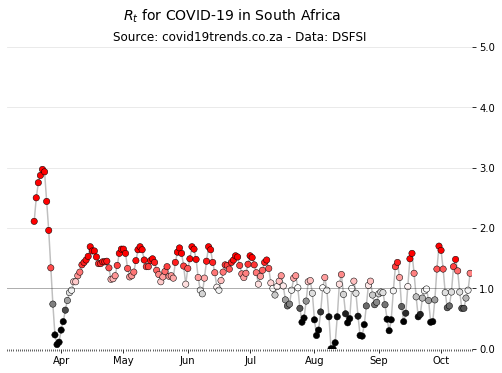

In [116]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [117]:
states_rt_i = states_all_rt_i.loc[state_filter]

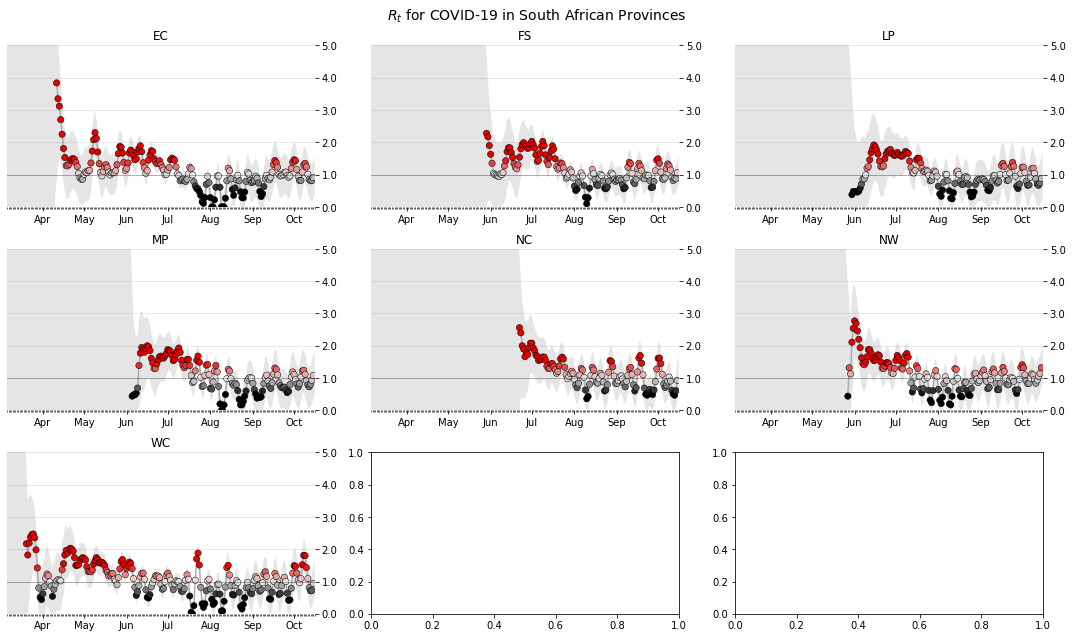

In [118]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [119]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [120]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

ML  High_90  Low_90
state                           
EC         0.91     1.44    0.28
FS         1.06     1.46    0.59
LP         0.88     1.54    0.16
MP         1.08     1.71    0.33
NC         0.93     1.46    0.32
NW         1.32     1.86    0.71
Total RSA  1.25     0.00    0.00
WC         0.94     1.43    0.39

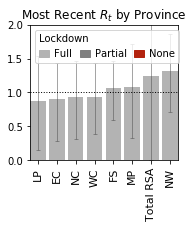

In [121]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

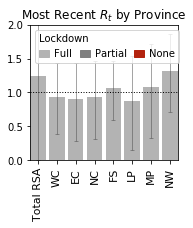

In [122]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

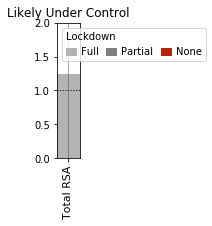

In [123]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

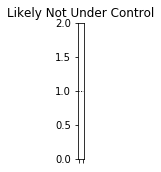

In [124]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()